## MISA Load and Query Model

This notebook loads the previously trained models for Ne, Te, and Ti, and defines some functions to use them.

#### Loading variables, defining functions

### 1a. Load

In [32]:
from MISA_pySLIME import *

In [48]:
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import cKDTree
import os
import netCDF4

# -- Define paths to large ancillary NetCDFs (downloaded at install/runtime) --
BASE_DIR       = os.path.dirname('../')
PROCESSED_DIR  = os.path.join(BASE_DIR, 'ancillary', 'processed_ncs')
MASTER_GEO_PATH = os.path.join(PROCESSED_DIR, 'master_geo_ds_2.0.6.nc')
master_geo_ds  = xr.load_dataset(MASTER_GEO_PATH,engine='netcdf4')

# -- Load geophysical index master dataset --
# -- Load trained binned-regression model dictionaries for Ne, Ti, Te --
MODEL_DIR      = os.path.join(BASE_DIR, 'model')
ne_model_dict = np.load(os.path.join(MODEL_DIR, 'ne_model_2_0_8.npy'), allow_pickle=True).item()
ti_model_dict = np.load(os.path.join(MODEL_DIR, 'ti_model_2_0_8.npy'), allow_pickle=True).item()
te_model_dict = np.load(os.path.join(MODEL_DIR, 'te_model_2_0_8.npy'), allow_pickle=True).item()

# -- Precompute bidirectional interpolators between (az, alt) and (lat, lon) --
GRID_PATH = os.path.join(PROCESSED_DIR, 'grid_ds_2.0.8.nc')
grid_ds   = xr.load_dataset(GRID_PATH)
flat_alt      = grid_ds['gdalt'].values.flatten()
flat_az       = grid_ds['az_normalized'].values.flatten()
flat_gdlat    = grid_ds['gdlat'].values.flatten()
flat_glon     = grid_ds['glon'].values.flatten()
interp_df = pd.DataFrame({
    'az':  flat_az,
    'alt': flat_alt,
    'lat': flat_gdlat,
    'lon': flat_glon
}).dropna()
# forward mapping: (az, alt) -> (lat, lon)
fwd_pts = interp_df[['az', 'alt']].values
lat_vals = interp_df['lat'].values
lon_vals = interp_df['lon'].values
# inverse mapping: (lat, lon) -> (az, alt)
inv_pts = interp_df[['lat', 'lon']].values
az_vals = interp_df['az'].values
alt_vals = interp_df['alt'].values
lat_interpolator = LinearNDInterpolator(fwd_pts, lat_vals)
lon_interpolator = LinearNDInterpolator(fwd_pts, lon_vals)
az_interpolator = LinearNDInterpolator(inv_pts, az_vals)
alt_interpolator = LinearNDInterpolator(inv_pts, alt_vals)
# Build KD-trees for nearest-neighbor fallback
fwd_tree = cKDTree(fwd_pts)  # (az, alt) -> (lat, lon)
inv_tree = cKDTree(inv_pts)  # (lat, lon) -> (az, alt)
# Domain bounds for more informative messages
az_min, az_max = interp_df['az'].min(), interp_df['az'].max()
alt_min, alt_max = interp_df['alt'].min(), interp_df['alt'].max()
lat_min, lat_max = interp_df['lat'].min(), interp_df['lat'].max()
lon_min, lon_max = interp_df['lon'].min(), interp_df['lon'].max()


def get_lat_lon(az, alt, verbose=True):
    az_arr = np.asarray(az)
    alt_arr = np.asarray(alt)
    pts = np.column_stack((az_arr.ravel(), alt_arr.ravel()))

    lat = lat_interpolator(pts)
    lon = lon_interpolator(pts)

    # Identify NaNs and replace with nearest neighbor
    nan_mask = np.isnan(lat) | np.isnan(lon)
    if np.any(nan_mask):
        bad_pts = pts[nan_mask]
        _, idxs = fwd_tree.query(bad_pts)
        nearest_valid = fwd_pts[idxs]
        lat[nan_mask] = lat_interpolator(nearest_valid)
        lon[nan_mask] = lon_interpolator(nearest_valid)
        if verbose:
            print(
                f"[get_lat_lon] {np.sum(nan_mask)} out-of-bounds point(s) detected.\n"
                f"Valid input ranges: az ∈ [{az_min:.2f}, {az_max:.2f}], alt ∈ [{alt_min:.2f}, {alt_max:.2f}].\n"
                f"Nearest valid grid points used instead."
            )

    return lat.reshape(az_arr.shape), lon.reshape(az_arr.shape)


def get_az_alt(lat, lon, verbose=True):
    lat_arr = np.asarray(lat)
    lon_arr = np.asarray(lon)
    pts = np.column_stack((lat_arr.ravel(), lon_arr.ravel()))

    az = az_interpolator(pts)
    alt = alt_interpolator(pts)

    # Identify NaNs and replace with nearest neighbor
    nan_mask = np.isnan(az) | np.isnan(alt)
    if np.any(nan_mask):
        bad_pts = pts[nan_mask]
        _, idxs = inv_tree.query(bad_pts)
        nearest_valid = inv_pts[idxs]
        az[nan_mask] = az_interpolator(nearest_valid)
        alt[nan_mask] = alt_interpolator(nearest_valid)
        if verbose:
            print(
                f"[get_az_alt] {np.sum(nan_mask)} out-of-bounds point(s) detected.\n"
                f"Valid input ranges: lat ∈ [{lat_min:.2f}, {lat_max:.2f}], lon ∈ [{lon_min:.2f}, {lon_max:.2f}].\n"
                f"Nearest valid grid points used instead."
            )
    return az.reshape(lat_arr.shape), alt.reshape(lat_arr.shape)


def query_model(az, alt, doy, slt, indices, bin_models, feature_order=None):
    """
    Generic binned-regression query function.
    """
    az_arr, alt_arr, doy_arr, slt_arr = map(np.atleast_1d, [az, alt, doy, slt])
    for k, v in indices.items():
        indices[k] = np.atleast_1d(v)
    n = az_arr.size
    # default feature order
    if feature_order is None:
        feature_order = ['doy', 'slt'] + sorted(indices.keys())
    # bin centers for fallback
    bin_centers = {key: ((info['az_range'][0] + info['az_range'][1]) / 2,
                         (info['alt_range'][0] + info['alt_range'][1]) / 2)
                   for key, info in bin_models.items()}
    preds = np.full(n, np.nan)
    for i in range(n):
        # exact bin match
        sel = None
        for key, info in bin_models.items():
            az0, az1 = info['az_range'];
            alt0, alt1 = info['alt_range']
            if az0 <= az_arr[i] < az1 and alt0 <= alt_arr[i] < alt1:
                sel = info;
                break
        # nearest fallback
        if sel is None:
            nearest = min(bin_centers, key=lambda k: np.hypot(
                az_arr[i] - bin_centers[k][0], alt_arr[i] - bin_centers[k][1]))
            sel = bin_models[nearest]
        # build features
        fv = []
        for feat in feature_order:
            if feat == 'doy':
                fv.append(doy_arr[i])
            elif feat == 'slt':
                fv.append(slt_arr[i])
            else:
                fv.append(indices[feat][i])
            # check if fv contains nans-1):
            if np.isnan(fv).any():
                raise ValueError(f"Feature {feat} contains NaN values.")
        X = np.array([fv])
        # scale + poly
        Xs = sel['scaler'].transform(X)
        if sel.get('poly') is not None:
            Xs = sel['poly'].transform(Xs)
        preds[i] = sel['model'].predict(Xs)[0]
    return preds[0] if n == 1 else preds


def _prepare_inputs(doy, time, coords, input_coords, time_ref, year=None):
    """
    Helper to convert and wrap inputs for generic prediction.
    """
    doy_arr = np.atleast_1d(doy).astype(float)
    time_arr = np.atleast_1d(time).astype(float)
    coords_arr = np.atleast_2d(coords).astype(float)
    if doy_arr.size != coords_arr.shape[0] or time_arr.size != coords_arr.shape[0]:
        raise ValueError('Length mismatch among recog, doy, time')
    # coords
    if input_coords == 'az_alt':
        az, alt = coords_arr[:, 0], coords_arr[:, 1]
        lat, lon = get_lat_lon(az, alt)
    else:
        lat, lon = coords_arr[:, 0], coords_arr[:, 1]
        az, alt = get_az_alt(lat, lon)
    # time to slt, ut
    if time_ref == 'slt':
        slt = time_arr; ut = slt - lon / 15.0
    else:
        ut = time_arr; slt = ut + lon / 15.0
    # wrap and adjust doy
    slt_mod = np.mod(slt, 24)
    ut_mod = np.mod(ut, 24)
    doy_arr += ((slt < 0).astype(int) - (slt >= 24).astype(int)
                + (ut < 0).astype(int) - (ut >= 24).astype(int))
    return az, alt, doy_arr, slt_mod, ut_mod


def predict_generic(doy, time, coords, model_dict, target_indices,
                    input_coords='az_alt', time_ref='slt', year=None,
                    geo_ds=master_geo_ds, verbose=False):
    """
    Core prediction routine for ne/ti/te using a binned model dict.
    """
    az, alt, doy_arr, slt, ut = _prepare_inputs(
        doy, time, coords, input_coords, time_ref, year)
    # filter geo data by year
    ds = geo_ds.sel(dates=geo_ds['dates'].dt.year == year) if year else geo_ds
    ds_dates = ds['dates'].dt.dayofyear.values
    preds = []
    for i in tqdm(range(len(az)), disable=not verbose):
        # filter by doy
        mask = ds_dates == doy_arr[i]
        if not mask.any(): raise ValueError(f'No geo data DOY {doy_arr[i]}')
        ds_doy = ds.isel(dates=mask)
        # closest ut
        ut_vals = ds_doy['ut'].values
        idx = np.abs(ut_vals - ut[i]).argmin()
        # build index dict
        idxs = {feat: float(ds_doy[feat].values[idx]) for feat in target_indices}
        preds.append(query_model(az[i], alt[i], doy_arr[i], slt[i], idxs, model_dict,
                                 ['doy', 'slt'] + target_indices))
    out = np.array(preds)
    return out[0] if out.size == 1 else out

# Convenience wrappers
predict_ne = lambda doy, time, coords, **kw: predict_generic(
    doy, time, coords, ne_model_dict, ['fism2_48hr_prior', 'ap_7hr_prior'], **kw)
predict_ti = lambda doy, time, coords, **kw: predict_generic(
    doy, time, coords, ti_model_dict, ['fism2_48hr_prior', 'ap_7hr_prior'], **kw)
predict_te = lambda doy, time, coords, **kw: predict_generic(
    doy, time, coords, te_model_dict, ['fism2_48hr_prior', 'ap_7hr_prior'], **kw)


In [49]:
import numpy as np

az_alt = np.array([
    [-43.14, 103.92],
    [-43.14, 119.19],
    [-43.14, 135.21],
    [-43.14, 151.99],
    [-43.14, 169.51],
    [-43.14, 187.78],
    [-43.14, 206.78],
    [-43.14, 226.51],
    [-43.14, 246.96],
    [-43.14, 268.13],
    [-43.14, 290.0 ],
    [-43.14, 312.58],
    [-43.14, 335.85],
    [-43.14, 359.81],
    [-43.14, 384.45],
    [-43.14, 409.76],
    [-43.14, 435.73],
    [-43.14, 462.37],
    [-43.14, 489.65],
    [-43.14, 517.57],
    [-48.17, 103.72],
    [-48.17, 118.96],
    [-48.17, 134.96],
    [-48.17, 151.72],
    [-48.17, 169.22],
    [-48.17, 187.46],
    [-48.17, 206.44],
    [-48.17, 226.15],
    [-48.17, 246.58],
    [-48.17, 267.72],
    [-48.17, 289.57],
    [-48.17, 312.13],
    [-48.17, 335.38],
    [-48.17, 359.31],
    [-48.17, 383.93],
    [-48.17, 409.22],
    [-48.17, 435.17],
    [-48.17, 461.78],
    [-48.17, 489.04],
    [-48.17, 516.95],
    [-53.22, 103.55],
    [-53.22, 118.78],
    [-53.22, 134.76],
    [-53.22, 151.5 ],
    [-53.22, 168.98],
    [-53.22, 187.21],
    [-53.22, 206.17],
    [-53.22, 225.85],
    [-53.22, 246.26],
    [-53.22, 267.39],
    [-53.22, 289.23],
    [-53.22, 311.76],
    [-53.22, 334.99],
    [-53.22, 358.91],
    [-53.22, 383.51],
    [-53.22, 408.78],
    [-53.22, 434.71],
    [-53.22, 461.31],
    [-53.22, 488.55],
    [-53.22, 516.44],
    [-58.07, 103.39],
    [-58.07, 118.59],
    [-58.07, 134.56],
    [-58.07, 151.28],
    [-58.07, 168.74],
    [-58.07, 186.95],
    [-58.07, 205.89],
    [-58.07, 225.56],
    [-58.07, 245.95],
    [-58.07, 267.06],
    [-58.07, 288.87],
    [-58.07, 311.39],
    [-58.07, 334.6 ],
    [-58.07, 358.5 ],
    [-58.07, 383.08],
    [-58.07, 408.34],
    [-58.07, 434.25],
    [-58.07, 460.83],
    [-58.07, 488.06],
    [-58.07, 515.92],
    [-63.1 , 103.21],
    [-63.1 , 118.4 ],
    [-63.1 , 134.34],
    [-63.1 , 151.04],
    [-63.1 , 168.49],
    [-63.1 , 186.67],
    [-63.1 , 205.6 ],
    [-63.1 , 225.25],
    [-63.1 , 245.62],
    [-63.1 , 266.71],
    [-63.1 , 288.5 ],
    [-63.1 , 311.  ],
    [-63.1 , 334.2 ],
    [-63.1 , 358.08],
    [-63.1 , 382.64],
    [-63.1 , 407.87],
    [-63.1 , 433.77],
    [-63.1 , 460.33],
    [-63.1 , 487.54],
    [-63.1 , 515.39],
    [-68.09, 103.03],
    [-68.09, 118.2 ],
    [-68.09, 134.12],
    [-68.09, 150.8 ],
    [-68.09, 168.23],
    [-68.09, 186.39],
    [-68.09, 205.3 ],
    [-68.09, 224.93],
    [-68.09, 245.28],
    [-68.09, 266.35],
    [-68.09, 288.13],
    [-68.09, 310.61],
    [-68.09, 333.78],
    [-68.09, 357.64],
    [-68.09, 382.19],
    [-68.09, 407.4 ],
    [-68.09, 433.28],
    [-68.09, 459.82],
    [-68.09, 487.01],
    [-68.09, 514.85],
    [-73.1 , 102.9 ],
    [-73.1 , 118.05],
    [-73.1 , 133.97],
    [-73.1 , 150.63],
    [-73.1 , 168.04],
    [-73.1 , 186.19],
    [-73.1 , 205.08],
    [-73.1 , 224.7 ],
    [-73.1 , 245.04],
    [-73.1 , 266.09],
    [-73.1 , 287.86],
    [-73.1 , 310.32],
    [-73.1 , 333.48],
    [-73.1 , 357.33],
    [-73.1 , 381.86],
    [-73.1 , 407.07],
    [-73.1 , 432.94],
    [-73.1 , 459.46],
    [-73.1 , 486.64],
    [-73.1 , 514.46],
    [-78.11, 102.71],
    [-78.11, 117.85],
    [-78.11, 133.74],
    [-78.11, 150.38],
    [-78.11, 167.77],
    [-78.11, 185.9 ],
    [-78.11, 204.77],
    [-78.11, 224.37],
    [-78.11, 244.69],
    [-78.11, 265.73],
    [-78.11, 287.47],
    [-78.11, 309.92],
    [-78.11, 333.06],
    [-78.11, 356.89],
    [-78.11, 381.4 ],
    [-78.11, 406.59],
    [-78.11, 432.44],
    [-78.11, 458.95],
    [-78.11, 486.11],
    [-78.11, 513.91],
    [-83.14, 102.47],
    [-83.14, 117.57],
    [-83.14, 133.44],
    [-83.14, 150.06],
    [-83.14, 167.42],
    [-83.14, 185.53],
    [-83.14, 204.37],
    [-83.14, 223.95],
    [-83.14, 244.24],
    [-83.14, 265.25],
    [-83.14, 286.97],
    [-83.14, 309.4 ],
    [-83.14, 332.52],
    [-83.14, 356.32],
    [-83.14, 380.81],
    [-83.14, 405.98],
    [-83.14, 431.81],
    [-83.14, 458.29],
    [-83.14, 485.43],
    [-83.14, 513.21],
    [-88.1 , 102.28],
    [-88.1 , 117.37],
    [-88.1 , 133.21],
    [-88.1 , 149.81],
    [-88.1 , 167.16],
    [-88.1 , 185.25],
    [-88.1 , 204.07],
    [-88.1 , 223.62],
    [-88.1 , 243.9 ],
    [-88.1 , 264.9 ],
    [-88.1 , 286.6 ],
    [-88.1 , 309.  ],
    [-88.1 , 332.11],
    [-88.1 , 355.9 ],
    [-88.1 , 380.37],
    [-88.1 , 405.52],
    [-88.1 , 431.33],
    [-88.1 , 457.8 ],
    [-88.1 , 484.92],
    [-88.1 , 512.69],
    [-93.09, 101.98],
    [-93.09, 117.04],
    [-93.09, 132.85],
    [-93.09, 149.42],
    [-93.09, 166.74],
    [-93.09, 184.79],
    [-93.09, 203.59],
    [-93.09, 223.11],
    [-93.09, 243.36],
    [-93.09, 264.32],
    [-93.09, 286.  ],
    [-93.09, 308.38],
    [-93.09, 331.45],
    [-93.09, 355.22],
    [-93.09, 379.66],
    [-93.09, 404.78],
    [-93.09, 430.57],
    [-93.09, 457.01],
    [-93.09, 484.11],
    [-93.09, 511.85],
    [-98.09, 101.86],
    [-98.09, 116.9 ],
    [-98.09, 132.7 ],
    [-98.09, 149.25],
    [-98.09, 166.56],
    [-98.09, 184.6 ],
    [-98.09, 203.39],
    [-98.09, 222.9 ],
    [-98.09, 243.14],
    [-98.09, 264.09],
    [-98.09, 285.75],
    [-98.09, 308.12],
    [-98.09, 331.19],
    [-98.09, 354.94],
    [-98.09, 379.37],
    [-98.09, 404.49],
    [-98.09, 430.26],
    [-98.09, 456.7 ],
    [-98.09, 483.79],
    [-98.09, 511.53],
    [-103.11, 101.79],
    [-103.11, 116.83],
    [-103.11, 132.62],
    [-103.11, 149.17],
    [-103.11, 166.47],
    [-103.11, 184.51],
    [-103.11, 203.29],
    [-103.11, 222.8 ],
    [-103.11, 243.03],
    [-103.11, 263.98],
    [-103.11, 285.64],
    [-103.11, 308.  ],
    [-103.11, 331.06],
    [-103.11, 354.81],
    [-103.11, 379.24],
    [-103.11, 404.35],
    [-103.11, 430.13],
    [-103.11, 456.56],
    [-103.11, 483.65],
    [-103.11, 511.38],
    [-108.1 , 101.56],
    [-108.1 , 116.57],
    [-108.1 , 132.34],
    [-108.1 , 148.87],
    [-108.1 , 166.14],
    [-108.1 , 184.16],
    [-108.1 , 202.92],
    [-108.1 , 222.41],
    [-108.1 , 242.62],
    [-108.1 , 263.54],
    [-108.1 , 285.18],
    [-108.1 , 307.53],
    [-108.1 , 330.57],
    [-108.1 , 354.3 ],
    [-108.1 , 378.71],
    [-108.1 , 403.8 ],
    [-108.1 , 429.56],
    [-108.1 , 455.98],
    [-108.1 , 483.05],
    [-108.1 , 510.77],
    [-113.31, 101.39],
    [-113.31, 116.39],
    [-113.31, 132.14],
    [-113.31, 148.65],
    [-113.31, 165.91],
    [-113.31, 183.92],
    [-113.31, 202.66],
    [-113.31, 222.13],
    [-113.31, 242.33],
    [-113.31, 263.24],
    [-113.31, 284.87],
    [-113.31, 307.2 ],
    [-113.31, 330.23],
    [-113.31, 353.95],
    [-113.31, 378.35],
    [-113.31, 403.43],
    [-113.31, 429.17],
    [-113.31, 455.58],
    [-113.31, 482.64],
    [-113.31, 510.35],
    [-118.14, 101.24],
    [-118.14, 116.22],
    [-118.14, 131.96],
    [-118.14, 148.46],
    [-118.14, 165.7 ],
    [-118.14, 183.69],
    [-118.14, 202.42],
    [-118.14, 221.88],
    [-118.14, 242.06],
    [-118.14, 262.97],
    [-118.14, 284.58],
    [-118.14, 306.9 ],
    [-118.14, 329.92],
    [-118.14, 353.62],
    [-118.14, 378.02],
    [-118.14, 403.08],
    [-118.14, 428.82],
    [-118.14, 455.22],
    [-118.14, 482.27],
    [-118.14, 509.97],
    [-123.13, 101.09],
    [-123.13, 116.06],
    [-123.13, 131.78],
    [-123.13, 148.27],
    [-123.13, 165.5 ],
    [-123.13, 183.48],
    [-123.13, 202.19],
    [-123.13, 221.64],
    [-123.13, 241.81],
    [-123.13, 262.7 ],
    [-123.13, 284.3 ],
    [-123.13, 306.61],
    [-123.13, 329.62],
    [-123.13, 353.32],
    [-123.13, 377.7 ],
    [-123.13, 402.76],
    [-123.13, 428.49],
    [-123.13, 454.88],
    [-123.13, 481.92],
    [-123.13, 509.61],
    [-128.17, 101.01],
    [-128.17, 115.97],
    [-128.17, 131.69],
    [-128.17, 148.16],
    [-128.17, 165.39],
    [-128.17, 183.36],
    [-128.17, 202.07],
    [-128.17, 221.51],
    [-128.17, 241.68],
    [-128.17, 262.57],
    [-128.17, 284.17],
    [-128.17, 306.47],
    [-128.17, 329.47],
    [-128.17, 353.17],
    [-128.17, 377.55],
    [-128.17, 402.6 ],
    [-128.17, 428.33],
    [-128.17, 454.72],
    [-128.17, 481.76],
    [-128.17, 509.45],
    [-133.15, 100.94],
    [-133.15, 115.89],
    [-133.15, 131.61],
    [-133.15, 148.08],
    [-133.15, 165.3 ],
    [-133.15, 183.26],
    [-133.15, 201.97],
    [-133.15, 221.41],
    [-133.15, 241.57],
    [-133.15, 262.45],
    [-133.15, 284.05],
    [-133.15, 306.35],
    [-133.15, 329.35],
    [-133.15, 353.04],
    [-133.15, 377.42],
    [-133.15, 402.48],
    [-133.15, 428.2 ],
    [-133.15, 454.59],
    [-133.15, 481.63],
    [-133.15, 509.32],
    [-138.17, 100.82],
    [-138.17, 115.77],
    [-138.17, 131.47],
    [-138.17, 147.93],
    [-138.17, 165.14],
    [-138.17, 183.1 ],
    [-138.17, 201.79],
    [-138.17, 221.22],
    [-138.17, 241.38],
    [-138.17, 262.25],
    [-138.17, 283.84],
    [-138.17, 306.14],
    [-138.17, 329.13],
    [-138.17, 352.82],
    [-138.17, 377.19],
    [-138.17, 402.24],
    [-138.17, 427.95],
    [-138.17, 454.34],
    [-138.17, 481.37],
    [-138.17, 509.06],
    [-143.14, 100.67],
    [-143.14, 115.59],
    [-143.14, 131.28],
    [-143.14, 147.73],
    [-143.14, 164.93],
    [-143.14, 182.87],
    [-143.14, 201.55],
    [-143.14, 220.97],
    [-143.14, 241.11],
    [-143.14, 261.97],
    [-143.14, 283.55],
    [-143.14, 305.83],
    [-143.14, 328.81],
    [-143.14, 352.49],
    [-143.14, 376.85],
    [-143.14, 401.89],
    [-143.14, 427.6 ],
    [-143.14, 453.97],
    [-143.14, 480.99],
    [-143.14, 508.67]
])

uts = np.array([
    19.2675, 19.2675, 19.2675, 19.2675, 19.2675, 19.2675,
    19.2675, 19.2675, 19.2675, 19.2675, 19.2675, 19.2675,
    19.2675, 19.2675, 19.2675, 19.2675, 19.2675, 19.2675,
    19.2675, 19.2675, 19.2775, 19.2775, 19.2775, 19.2775,
    19.2775, 19.2775, 19.2775, 19.2775, 19.2775, 19.2775,
    19.2775, 19.2775, 19.2775, 19.2775, 19.2775, 19.2775,
    19.2775, 19.2775, 19.2775, 19.2775, 19.28694444, 19.28694444,
    19.28694444, 19.28694444, 19.28694444, 19.28694444, 19.28694444, 19.28694444,
    19.28694444, 19.28694444, 19.28694444, 19.28694444, 19.28694444, 19.28694444,
    19.28694444, 19.28694444, 19.28694444, 19.28694444, 19.28694444, 19.28694444,
    19.29666667, 19.29666667, 19.29666667, 19.29666667, 19.29666667, 19.29666667,
    19.29666667, 19.29666667, 19.29666667, 19.29666667, 19.29666667, 19.29666667,
    19.29666667, 19.29666667, 19.29666667, 19.29666667, 19.29666667, 19.29666667,
    19.29666667, 19.29666667, 19.30638889, 19.30638889, 19.30638889, 19.30638889,
    19.30638889, 19.30638889, 19.30638889, 19.30638889, 19.30638889, 19.30638889,
    19.30638889, 19.30638889, 19.30638889, 19.30638889, 19.30638889, 19.30638889,
    19.30638889, 19.30638889, 19.30638889, 19.30638889, 19.31611111, 19.31611111,
    19.31611111, 19.31611111, 19.31611111, 19.31611111, 19.31611111, 19.31611111,
    19.31611111, 19.31611111, 19.31611111, 19.31611111, 19.31611111, 19.31611111,
    19.31611111, 19.31611111, 19.31611111, 19.31611111, 19.31611111, 19.31611111,
    19.32583333, 19.32583333, 19.32583333, 19.32583333, 19.32583333, 19.32583333,
    19.32583333, 19.32583333, 19.32583333, 19.32583333, 19.32583333, 19.32583333,
    19.32583333, 19.32583333, 19.32583333, 19.32583333, 19.32583333, 19.32583333,
    19.32583333, 19.32583333, 19.33555556, 19.33555556, 19.33555556, 19.33555556,
    19.33555556, 19.33555556, 19.33555556, 19.33555556, 19.33555556, 19.33555556,
    19.33555556, 19.33555556, 19.33555556, 19.33555556, 19.33555556, 19.33555556,
    19.33555556, 19.33555556, 19.33555556, 19.33555556, 19.34527778, 19.34527778,
    19.34527778, 19.34527778, 19.34527778, 19.34527778, 19.34527778, 19.34527778,
    19.34527778, 19.34527778, 19.34527778, 19.34527778, 19.34527778, 19.34527778,
    19.34527778, 19.34527778, 19.34527778, 19.34527778, 19.34527778, 19.34527778,
    19.355,       19.355,       19.355,       19.355,       19.355,       19.355,
    19.355,       19.355,       19.355,       19.355,       19.355,       19.355,
    19.355,       19.355,       19.355,       19.355,       19.355,       19.355,
    19.355,       19.355,       19.36472222, 19.36472222, 19.36472222, 19.36472222,
    19.36472222, 19.36472222, 19.36472222, 19.36472222, 19.36472222, 19.36472222,
    19.36472222, 19.36472222, 19.36472222, 19.36472222, 19.36472222, 19.36472222,
    19.36472222, 19.36472222, 19.36472222, 19.36472222, 19.37444444, 19.37444444,
    19.37444444, 19.37444444, 19.37444444, 19.37444444, 19.37444444, 19.37444444,
    19.37444444, 19.37444444, 19.37444444, 19.37444444, 19.37444444, 19.37444444,
    19.37444444, 19.37444444, 19.37444444, 19.37444444, 19.37444444, 19.37444444,
    19.38416667, 19.38416667, 19.38416667, 19.38416667, 19.38416667, 19.38416667,
    19.38416667, 19.38416667, 19.38416667, 19.38416667, 19.38416667, 19.38416667,
    19.38416667, 19.38416667, 19.38416667, 19.38416667, 19.38416667, 19.38416667,
    19.38416667, 19.38416667, 19.39388889, 19.39388889, 19.39388889, 19.39388889,
    19.39388889, 19.39388889, 19.39388889, 19.39388889, 19.39388889, 19.39388889,
    19.39388889, 19.39388889, 19.39388889, 19.39388889, 19.39388889, 19.39388889,
    19.39388889, 19.39388889, 19.39388889, 19.39388889, 19.40361111, 19.40361111,
    19.40361111, 19.40361111, 19.40361111, 19.40361111, 19.40361111, 19.40361111,
    19.40361111, 19.40361111, 19.40361111, 19.40361111, 19.40361111, 19.40361111,
    19.40361111, 19.40361111, 19.40361111, 19.40361111, 19.40361111, 19.40361111,
    19.41333333, 19.41333333, 19.41333333, 19.41333333, 19.41333333, 19.41333333,
    19.41333333, 19.41333333, 19.41333333, 19.41333333, 19.41333333, 19.41333333,
    19.41333333, 19.41333333, 19.41333333, 19.41333333, 19.41333333, 19.41333333,
    19.41333333, 19.41333333, 19.42305556, 19.42305556, 19.42305556, 19.42305556,
    19.42305556, 19.42305556, 19.42305556, 19.42305556, 19.42305556, 19.42305556,
    19.42305556, 19.42305556, 19.42305556, 19.42305556, 19.42305556, 19.42305556,
    19.42305556, 19.42305556, 19.42305556, 19.42305556, 19.43277778, 19.43277778,
    19.43277778, 19.43277778, 19.43277778, 19.43277778, 19.43277778, 19.43277778,
    19.43277778, 19.43277778, 19.43277778, 19.43277778, 19.43277778, 19.43277778,
    19.43277778, 19.43277778, 19.43277778, 19.43277778, 19.43277778, 19.43277778,
    19.4425,     19.4425,     19.4425,     19.4425,     19.4425,     19.4425,
    19.4425,     19.4425,     19.4425,     19.4425,     19.4425,     19.4425,
    19.4425,     19.4425,     19.4425,     19.4425,     19.4425,     19.4425,
    19.4425,     19.4425,     19.45222222, 19.45222222, 19.45222222, 19.45222222,
    19.45222222, 19.45222222, 19.45222222, 19.45222222, 19.45222222, 19.45222222,
    19.45222222, 19.45222222, 19.45222222, 19.45222222, 19.45222222, 19.45222222,
    19.45222222, 19.45222222, 19.45222222, 19.45222222, 19.46194444, 19.46194444,
    19.46194444, 19.46194444, 19.46194444, 19.46194444, 19.46194444, 19.46194444,
    19.46194444, 19.46194444, 19.46194444, 19.46194444, 19.46194444, 19.46194444,
    19.46194444, 19.46194444, 19.46194444, 19.46194444, 19.46194444, 19.46194444
])



In [50]:
doyin=99*np.ones(az_alt.shape[0])
ne = predict_ne(
    coords=az_alt,
    doy=doyin,
    time=uts,
    year=2024,
    input_coords='az_alt',  # or 'lat_lon'
    time_ref='ut'           # 'slt' or 'ut'
)

[get_lat_lon] 75 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.


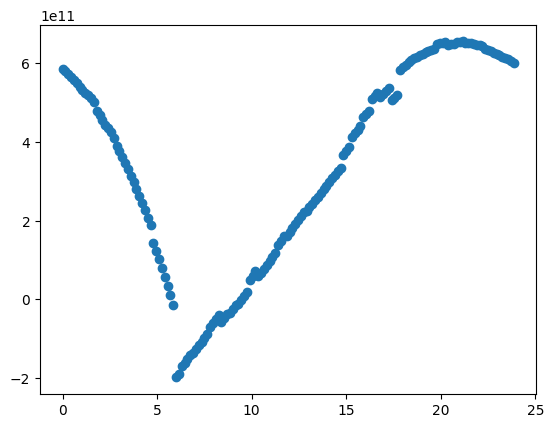

In [51]:
from matplotlib import pyplot as plt
import numpy as np
# evaluate predictions
predictions = [
    predict_ne(
        coords = (-80,350),
        doy=99,
        time=time,
        year=2024,
        input_coords='az_alt',
        time_ref='ut'
    )
    for time in np.arange(0,24,0.15)
]

plt.scatter(np.arange(0,24,0.15), predictions, label='Predictions')
# plt.ylim(0, 1e12)

### load/bin a test day, compare with residuals with model

In [30]:
from datetime import datetime
### load data
def timestamp_to_decimal_hour(timestamp):
    utc_time = datetime.utcfromtimestamp(timestamp)
    return utc_time.hour + utc_time.minute / 60 + utc_time.second / 3600

test_date = np.datetime64('2024-04-15') # define the test date
test_xr = xr.open_dataset('/Users/mateo/Documents/dev/Haystack/AzimuthalScans/content/EclipseReport/mlh240415k.004.nc') # make sure to use the correct data product


### recorded data product processing
# Construct UT from UTC timestamp and attach to test dataset
dates = []
times = test_xr['timestamps'].data
ut = np.zeros(len(times))
for i in range(len(times)):
    temp = datetime.utcfromtimestamp(times[i])
    dates.append(temp)
    ut[i] = temp.hour + temp.minute / 60.0 + temp.second / 3600.0
# Convert the list of datetime objects to a pandas DatetimeIndex
pd_dates = pd.to_datetime(dates)
# Add the dates as a new coordinate in the xarray Dataset and set it as a dimension
test_xr = test_xr.assign_coords(dates=('timestamps', pd_dates))
test_xr = test_xr.swap_dims({'timestamps': 'dates'})
# Add UT hour variable to the dataset
ut = [timestamp_to_decimal_hour(ts) for ts in test_xr.timestamps.data]
test_xr['ut'] = (('dates',), ut)
test_xr['ut'].attrs = {
    "units": "hour of the day in decimal format",
    "long_name": "Universal Time Hour",
    "description": "Time in UTC expressed as a decimal hour."
}
# Add te variable to the dataset
test_xr['te'] = test_xr['tr'] * test_xr['ti']
test_xr['dte'] = test_xr['dtr'] * test_xr['dti']
# Add SLT variable to the dataset
slt = (test_xr.glon/15) + test_xr.ut # calculate correct SLT
test_xr['slt'] = (slt)
test_xr['slt'].attrs = {
    "units": "hours",
    "long_name": "Solar Local Time",
    "description": "Time in hours of the day, adjusted for longitude."
}
test_xr['az_normalized'] = (test_xr['az1'] + test_xr['az2']) / 2 # normalize az

# reindex the xr according to recorded dates dim
master_geo_ds_reindexed = master_geo_ds.reindex(dates=test_xr['dates'], method='ffill') 
for var in master_geo_ds_reindexed.var(): # append indices to radar data
    test_xr[var] = master_geo_ds_reindexed[var]

### bin data by azimuth and generate modeled day with identical conditions
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

### target params
# target azimuth and width
target_az = -80
daz = 5
# Define bins for parameters
bins = {
    'alt': np.arange(101, 490, 25),  # Altitude bins (0-500 km, 50 km steps)
    'slt': np.arange(6, 19, .5) # time bins
}

# load and mask
target_xr = test_xr.copy(deep=True)
target_xr = target_xr.where(target_xr['dates'].dt.date == np.datetime64(test_date),drop=False) # target april 7th
az_mask = (target_xr['az1'] > (target_az - daz)) & (target_xr['az1'] < (target_az + daz))
target_xr = target_xr.where(az_mask, drop=True)
doy = pd.Timestamp(test_date).dayofyear


# ut_value = pd.Timestamp(target_xr.dates.data).hour + pd.Timestamp(target_xr.dates.data).minute / 60 + pd.Timestamp(target_xr.dates.data).second / 3600
# Adjust the shapes to match the number of bins (edges - 1)
n_alt_bins = len(bins['alt']) - 1
n_slt_bins = len(bins['slt']) - 1

Z = np.zeros((n_alt_bins, n_slt_bins))
Z_modeled = np.zeros((n_alt_bins, n_slt_bins))
lats = np.zeros((n_alt_bins, n_slt_bins))
lons = np.zeros((n_alt_bins, n_slt_bins))
r2s = np.zeros(len(bins['alt']))
for i,alt in enumerate(tqdm(bins['alt'][:-1])):
    alt_mask = (target_xr.gdalt >= bins['alt'][i]) & (target_xr.gdalt < bins['alt'][i+1])
    alt_masked_xr = target_xr.where(alt_mask, drop=False)
    # xr_alt = target_xr.where(alt_mask, drop=True)
    target_values_row = []
    modeled_values_row = []
    for j,slt in enumerate(bins['slt'][:-1]):
        slt_mask = (alt_masked_xr.slt >= bins['slt'][j]) & (alt_masked_xr.slt < bins['slt'][j+1])
        target_lats = alt_masked_xr.gdlat.where(slt_mask,drop=True).data.flatten()
        target_lons = alt_masked_xr.glon.where(slt_mask,drop=True).data.flatten()
        target_values = alt_masked_xr['ti'].where(slt_mask,drop=True).data.flatten()
        if len(target_values) == 0:
            Z[i,j] = np.nan
            continue
        # target_ap30s = alt_masked_xr.ap30.where(ut_mask,drop=True).data.flatten()
        # target_fism2s = alt_masked_xr.fism2.where(ut_mask,drop=True).data.flatten()
        # target_smes = alt_masked_xr.sme.where(ut_mask, drop=True).data.flatten()

        target_azs = np.repeat(target_az, len(target_lats))
        target_alts = np.repeat(alt, len(target_lats))
        target_slts = np.repeat(slt, len(target_lats))
        target_doys = np.repeat(doy, len(target_lats))

        # modeled_values = predict_ne_poly(target_azs,target_alts,target_uts,target_ap30s,target_fism2s,target_smes,bin_models)
        # modeled_values = predict_ti(target_azs,target_alts,target_doys,target_slts,year=2024)
        modeled_values = predict_ti(
        coords = list(zip(target_azs.tolist(),target_alts.tolist())),
        doy=target_doys,
        time=target_slts,
        year=2024,
        input_coords='az_alt',
        time_ref='slt'
    )

        # doys= np.repeat(doy,len(target_values))
        # slts = np.repeat(slt,len(target_values))
        # alts = np.repeat(alt,len(target_values))

        # append recorded data to master list
        Z[i,j] = np.nanmean(target_values)
        Z_modeled[i,j] = np.mean(modeled_values)

        lats[i,j] = np.nanmean(target_lats) # good approx
        lons[i,j] = np.nanmean(target_lons) # good approx
    # r2 = r2_score(modeled_values_row, target_values_row)
    # r2s[i] = r2

  0%|          | 0/15 [00:00<?, ?it/s]

[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.
[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.
[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.
[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.
[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.
[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid input ranges: az ∈ [-141.16, -45.09], alt ∈ [100.81, 509.99].
Nearest valid grid points used instead.
[get_lat_lon] 4 out-of-bounds point(s) detected.
Valid inp

100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


/var/folders/46/7rtdvrg92h175wj3d6dq0zjr0000gn/T/ipykernel_76400/304448936.py:34: UserWarning: The following kwargs were not used by contour: 'extendfrac'
  cs = ax.contourf(


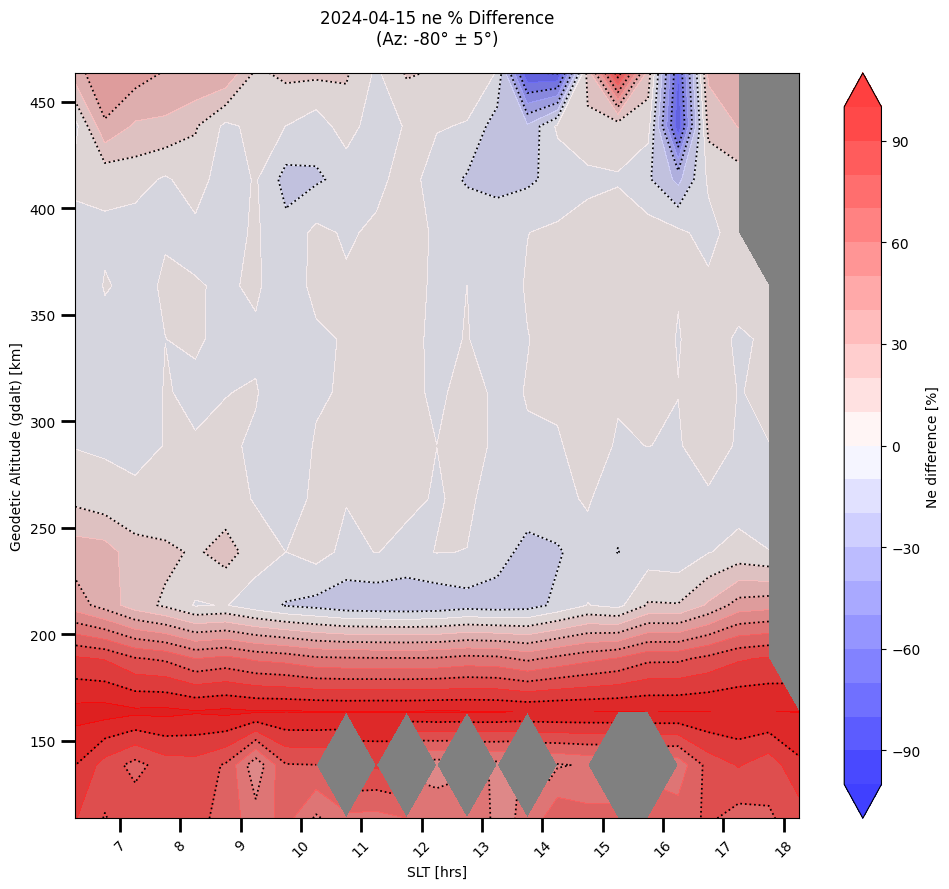

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Example levels for ±100% difference in 21 steps
levels = np.linspace(-100, 100, 21)

# Compute the midpoints of the bins.
alt_midpoints = (bins['alt'][:-1] + bins['alt'][1:]) / 2
slt_midpoints = (bins['slt'][:-1] + bins['slt'][1:]) / 2

# Create a meshgrid from the midpoints so the grid matches the shape of difference_percent.
X, Y = np.meshgrid(slt_midpoints, alt_midpoints)

# Compute the difference percent (ensure Z and Z_modeled are of shape (n_alt_bins, n_slt_bins))
difference_percent = (((Z - Z_modeled) / Z) * 100)

# Create a copy of the 'bwr' colormap and set the 'bad' (NaN) color to grey
cmap = plt.get_cmap('bwr').copy()
cmap.set_bad(color='grey')

fig, ax = plt.subplots(figsize=(10, 9))

# (1) Optional line contours (in black, dotted)
cs2 = ax.contour(
    X, Y, difference_percent,
    levels=levels[1::2],      # e.g. every other level for line contours
    colors='black',
    linewidths=1.25,
    linestyles='dotted'
)

# (2) Filled contours - set NaN areas to grey
cs = ax.contourf(
    X, Y, difference_percent,
    levels=levels,
    cmap=cmap,
    extend='both',  # so color extends beyond min/max
    extendfrac='auto',
    alpha=0.75
)

cbar = plt.colorbar(cs, ax=ax, label='Ne difference [%]')

# Set axis labels and facecolor
ax.set_xlabel('SLT [hrs]')
ax.set_ylabel('Geodetic Altitude (gdalt) [km]')
ax.set_facecolor('grey')

title = f'{test_date} ne % Difference\n(Az: {target_az}° ± {daz}°)'
ax.set_title(title + '\n')

# Format x-axis with custom time labels if needed
# ax.xaxis.set_major_formatter(plt.FuncFormatter(ut_to_hhmm))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=23))
ax.tick_params(length=10, width=2)
plt.xticks(rotation=45)

# Adjust plot limits based on the bin edges (or midpoints)
ax.set_xlim(slt_midpoints[0], slt_midpoints[-1])
ax.set_ylim(alt_midpoints[0], alt_midpoints[-1])

plt.tight_layout()
plt.show()

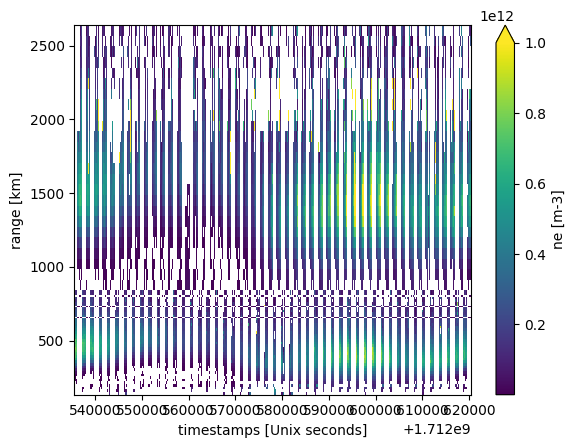

In [ ]:
test_xr = xr.open_dataset('/Users/mateo/Documents/dev/Haystack/AzimuthalScans/content/EclipseReport/mlh240408k.004.nc')
test_xr.ne.T.plot(vmax=1e12)